In [32]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

from sklearn.metrics import f1_score
from keras.callbacks import Callback
import numpy as np
import fasttext.util
import pickle

In [33]:
train_data = json.load(open('../Dataset/BIO_Tagged/ATE_train.json'))
val_data = json.load(open('../Dataset/BIO_Tagged/ATE_val.json'))
test_data = json.load(open('../Dataset/BIO_Tagged/ATE_test.json'))

In [34]:
word2vec = pickle.load(open('Word Embeddings/word2vec.pkl', 'rb'))
glove = pickle.load(open('Word Embeddings/glove.pkl', 'rb'))
# Add another embedding here

In [35]:
def prepareData(train_data, embedding_type):
    X, Y = [], []
    for data in train_data:
        X.append(train_data[data]['text'].split())
        Y.append(train_data[data]['labels'])
    
    num_words = len(set([word.lower() for sentence in X for word in sentence]))
    num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

    word_tokenizer = Tokenizer()                      
    word_tokenizer.fit_on_texts(X)                    
    X_encoded = word_tokenizer.texts_to_sequences(X)

    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(Y)
    Y_encoded = tag_tokenizer.texts_to_sequences(Y)
    
    max_seq_length = 50

    X_padded = pad_sequences(X_encoded, maxlen=max_seq_length, padding="pre", truncating="post")
    Y_padded = pad_sequences(Y_encoded, maxlen=max_seq_length, padding="pre", truncating="post")

    X, Y = X_padded, Y_padded

    embedding_matrix = np.zeros((num_words+1, 300))
    
    word2id = word_tokenizer.word_index
    for word, index in word2id.items():
        try:
            embedding_matrix[index, :] = embedding_type[word]
        except KeyError:
            pass    

    Y = to_categorical(Y)

    return X,Y, embedding_matrix

In [36]:
data = {}
data['word2vec'] = {}
data['glove'] = {}

data['word2vec']['X_train'], data['word2vec']['Y_train'], data['word2vec']['train_embedding_matrix'] = prepareData(train_data, word2vec)
data['word2vec']['X_val'], data['word2vec']['Y_val'], data['word2vec']['val_embedding_matrix'] = prepareData(val_data, word2vec)
data['word2vec']['X_test'], data['word2vec']['Y_test'], data['word2vec']['test_embedding_matrix'] = prepareData(test_data, word2vec)

data['glove']['X_train'], data['glove']['Y_train'], data['glove']['train_embedding_matrix'] = prepareData(train_data, glove)
data['glove']['X_val'], data['glove']['Y_val'], data['glove']['val_embedding_matrix'] = prepareData(val_data, glove)
data['glove']['X_test'], data['glove']['Y_test'], data['glove']['test_embedding_matrix'] = prepareData(test_data, glove)

In [37]:
class MacroF1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = np.argmax(self.model.predict(self.train_data[0]), axis=-1)
        train_true = np.argmax(self.train_data[1], axis=-1)
        train_f1 = f1_score(train_true.flatten(), train_pred.flatten(), average='macro')

        val_pred = np.argmax(self.model.predict(self.val_data[0]), axis=-1)
        val_true = np.argmax(self.val_data[1], axis=-1)
        val_f1 = f1_score(val_true.flatten(), val_pred.flatten(), average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        print(f'Epoch {epoch + 1} - Train Macro-F1: {train_f1:.4f} - Val Macro-F1: {val_f1:.4f}')


## VANILLA RNN

In [38]:
def trainRNN(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    rnn_model.add(SimpleRNN(64, return_sequences=True))

    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 3ms/step
Epoch 1 - Train Macro-F1: 0.4744 - Val Macro-F1: 0.4696
8/8 [==============================] - 1s 65ms/step - loss: 1.1861 - acc: 0.4634 - val_loss: 0.9375 - val_acc: 0.9205
Epoch 2/10
7/7 [==============================] - 0s 2ms/step
Epoch 2 - Train Macro-F1: 0.4557 - Val Macro-F1: 0.4504
8/8 [==============================] - 0s 39ms/step - loss: 0.7715 - acc: 0.9116 - val_loss: 0.5806 - val_acc: 0.8885
Epoch 3/10
7/7 [==============================] - 0s 2ms/step
Epoch 3 - Train Macro-F1: 0.5233 - Val Macro-F1: 0.4625
8/8 [==============================] - 0s 41ms/step - loss: 0.4510 - acc: 0.8919 - val_loss: 0.3881 - val_acc: 0.8917
Epoch 4/10
7/7 [==============================] - 0s 2ms/step
Epoch 4 - Train Macro-F1: 0.5214 - Val Macro-F1: 0.4702
8/8 [==============================] - 0s 46ms/step - loss: 0.3071 - acc: 0.9091 - val_loss: 0.3168 - val_acc: 0.9040
Epoch 5/10
7/7 [==============================] - 0s 2ms

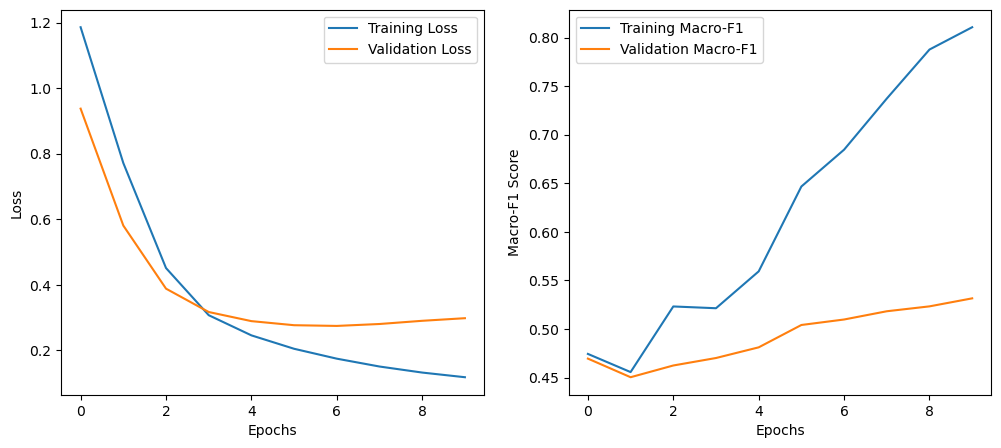

In [39]:
trainRNN('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 3ms/step
Epoch 1 - Train Macro-F1: 0.4875 - Val Macro-F1: 0.4724
8/8 [==============================] - 1s 60ms/step - loss: 1.0254 - acc: 0.8615 - val_loss: 0.5546 - val_acc: 0.9197
Epoch 2/10
7/7 [==============================] - 0s 2ms/step
Epoch 2 - Train Macro-F1: 0.5245 - Val Macro-F1: 0.4812
8/8 [==============================] - 0s 42ms/step - loss: 0.4260 - acc: 0.9103 - val_loss: 0.3642 - val_acc: 0.9005
Epoch 3/10
7/7 [==============================] - 0s 2ms/step
Epoch 3 - Train Macro-F1: 0.6016 - Val Macro-F1: 0.5163
8/8 [==============================] - 0s 41ms/step - loss: 0.2919 - acc: 0.9150 - val_loss: 0.3075 - val_acc: 0.9042
Epoch 4/10
7/7 [==============================] - 0s 2ms/step
Epoch 4 - Train Macro-F1: 0.6332 - Val Macro-F1: 0.5193
8/8 [==============================] - 0s 41ms/step - loss: 0.2337 - acc: 0.9308 - val_loss: 0.2826 - val_acc: 0.9090
Epoch 5/10
7/7 [==============================] - 0s 2ms

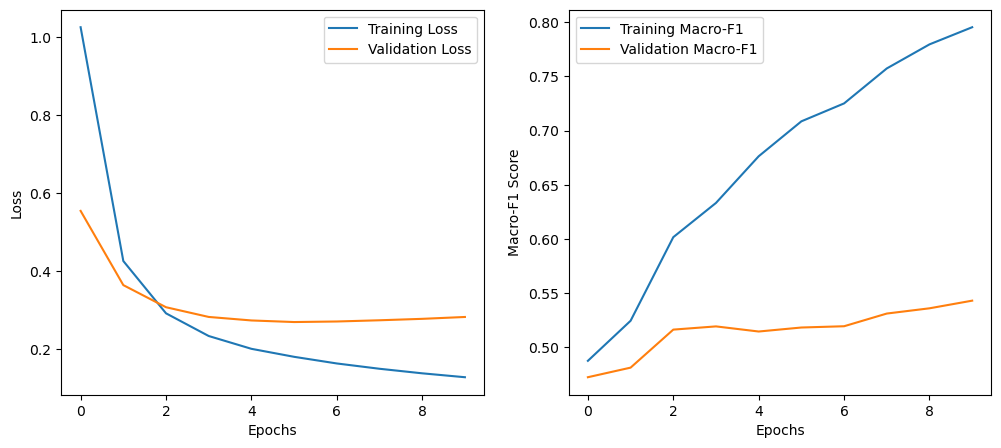

In [40]:
trainRNN('glove')

## LSTM

In [41]:
def trainLSTM(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    lstm_model.add(LSTM(64, return_sequences=True))

    lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4689 - Val Macro-F1: 0.4689
8/8 [==============================] - 2s 116ms/step - loss: 1.2331 - acc: 0.9020 - val_loss: 0.9949 - val_acc: 0.9201
Epoch 2/10
7/7 [==============================] - 0s 6ms/step
Epoch 2 - Train Macro-F1: 0.4450 - Val Macro-F1: 0.4440
8/8 [==============================] - 1s 80ms/step - loss: 0.8279 - acc: 0.9068 - val_loss: 0.5731 - val_acc: 0.8781
Epoch 3/10
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.4555 - Val Macro-F1: 0.4549
8/8 [==============================] - 1s 79ms/step - loss: 0.5050 - acc: 0.8722 - val_loss: 0.4075 - val_acc: 0.8963
Epoch 4/10
7/7 [==============================] - 0s 6ms/step
Epoch 4 - Train Macro-F1: 0.4615 - Val Macro-F1: 0.4609
8/8 [==============================] - 1s 84ms/step - loss: 0.3680 - acc: 0.9049 - val_loss: 0.3354 - val_acc: 0.9069
Epoch 5/10
7/7 [==============================] - 0s 7m

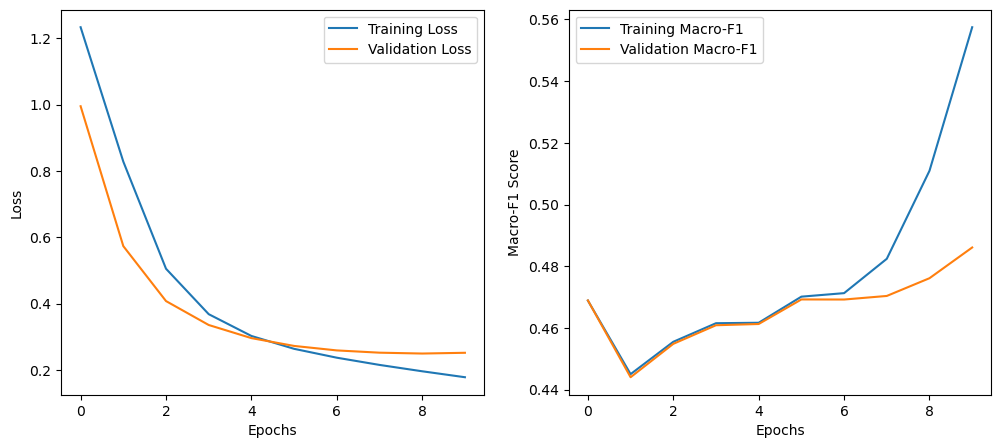

In [42]:
trainLSTM('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 6ms/step
Epoch 1 - Train Macro-F1: 0.4727 - Val Macro-F1: 0.4720
8/8 [==============================] - 1s 115ms/step - loss: 1.1477 - acc: 0.9020 - val_loss: 0.9660 - val_acc: 0.9251
Epoch 2/10
7/7 [==============================] - 0s 6ms/step
Epoch 2 - Train Macro-F1: 0.4578 - Val Macro-F1: 0.4579
8/8 [==============================] - 1s 81ms/step - loss: 0.8084 - acc: 0.9185 - val_loss: 0.5623 - val_acc: 0.8998
Epoch 3/10
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.4731 - Val Macro-F1: 0.4632
8/8 [==============================] - 1s 81ms/step - loss: 0.4740 - acc: 0.8869 - val_loss: 0.4055 - val_acc: 0.8937
Epoch 4/10
7/7 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.4923 - Val Macro-F1: 0.4756
8/8 [==============================] - 1s 87ms/step - loss: 0.3344 - acc: 0.9035 - val_loss: 0.3262 - val_acc: 0.9185
Epoch 5/10
7/7 [==============================] - 0s 7m

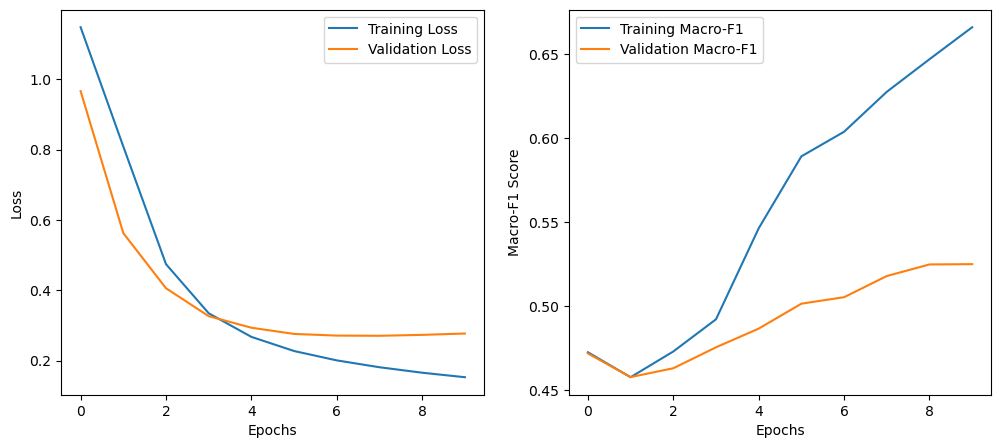

In [43]:
trainLSTM('glove')

## GRU

In [44]:
def trainGRU(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    gru_model.add(GRU(64, return_sequences=True))

    gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4715 - Val Macro-F1: 0.4720
8/8 [==============================] - 1s 104ms/step - loss: 1.2616 - acc: 0.8820 - val_loss: 1.0546 - val_acc: 0.9252
Epoch 2/10
7/7 [==============================] - 0s 5ms/step
Epoch 2 - Train Macro-F1: 0.4706 - Val Macro-F1: 0.4711
8/8 [==============================] - 1s 73ms/step - loss: 0.9009 - acc: 0.9226 - val_loss: 0.6476 - val_acc: 0.9236
Epoch 3/10
7/7 [==============================] - 0s 5ms/step
Epoch 3 - Train Macro-F1: 0.4595 - Val Macro-F1: 0.4594
8/8 [==============================] - 1s 72ms/step - loss: 0.4853 - acc: 0.9137 - val_loss: 0.3481 - val_acc: 0.9041
Epoch 4/10
7/7 [==============================] - 0s 5ms/step
Epoch 4 - Train Macro-F1: 0.4616 - Val Macro-F1: 0.4599
8/8 [==============================] - 1s 73ms/step - loss: 0.3006 - acc: 0.9009 - val_loss: 0.2983 - val_acc: 0.9050
Epoch 5/10
7/7 [==============================] - 0s 6m

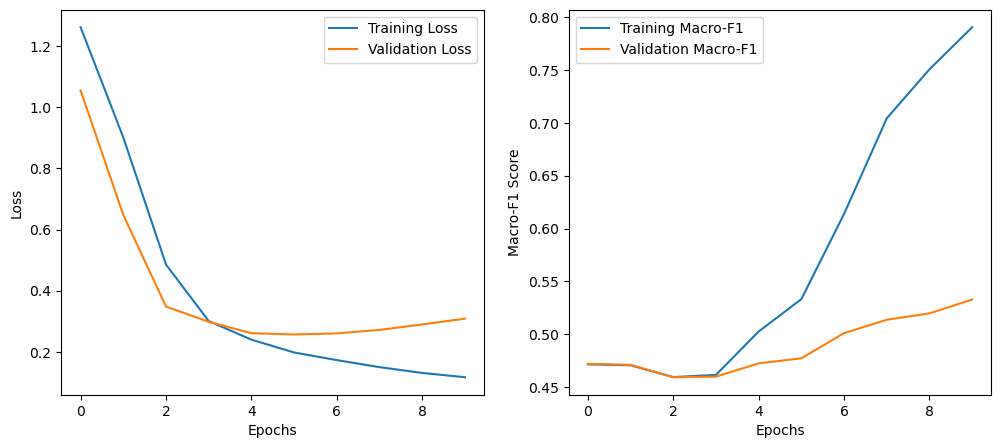

In [45]:
trainGRU('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4757 - Val Macro-F1: 0.4743
8/8 [==============================] - 1s 104ms/step - loss: 1.1364 - acc: 0.8876 - val_loss: 0.9423 - val_acc: 0.9262
Epoch 2/10
7/7 [==============================] - 0s 6ms/step
Epoch 2 - Train Macro-F1: 0.4794 - Val Macro-F1: 0.4732
8/8 [==============================] - 1s 78ms/step - loss: 0.8086 - acc: 0.9238 - val_loss: 0.6128 - val_acc: 0.9256
Epoch 3/10
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.5252 - Val Macro-F1: 0.4821
8/8 [==============================] - 1s 75ms/step - loss: 0.4238 - acc: 0.9240 - val_loss: 0.2953 - val_acc: 0.9185
Epoch 4/10
7/7 [==============================] - 0s 6ms/step
Epoch 4 - Train Macro-F1: 0.5709 - Val Macro-F1: 0.5001
8/8 [==============================] - 1s 81ms/step - loss: 0.2334 - acc: 0.9255 - val_loss: 0.2679 - val_acc: 0.9071
Epoch 5/10
7/7 [==============================] - 0s 6m

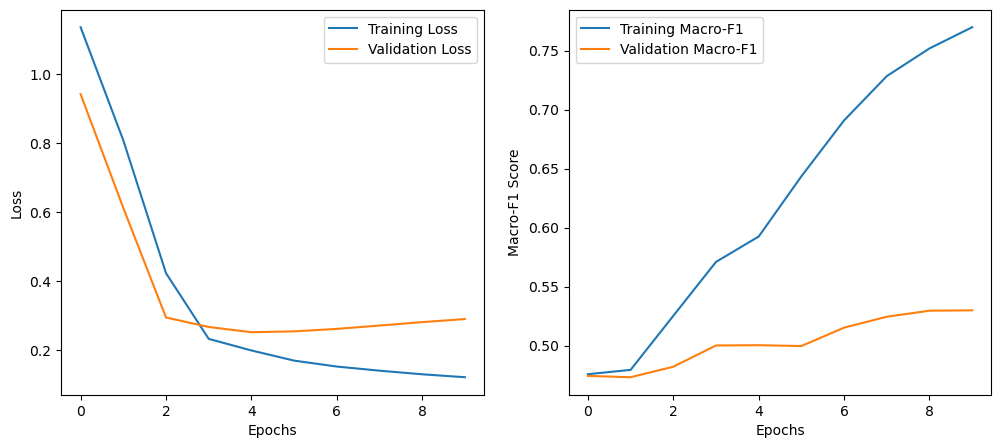

In [46]:
trainGRU('glove')